In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import json


In [29]:
# Load and inspect station data
with open('data/266322010.json', 'r') as file:
    json_data = json.load(file)
parsed_data = json_data[0]["data"]
station_df = pd.DataFrame(parsed_data, columns=["Timestamp", "Value"])

# Load weather data
weather_df = pd.read_csv('data/weather-data.csv', sep=';')


In [33]:
# Data preprocessing - Station data
station_df['Timestamp'] = pd.to_datetime(station_df['Timestamp'], errors='coerce')

# Check for conversion issues
if station_df['Timestamp'].isna().any():
    print("Warning: There are NaT values in the 'Timestamp' column")

# Make timezone naive
station_df['Timestamp'] = station_df['Timestamp'].dt.tz_localize(None)

# Convert to hourly averages
station_hourly = station_df.set_index('Timestamp').resample('H').mean()
station_hourly = station_hourly.rename(columns={'Value': 'Abfluss'})
print("\nHourly station data:")
print(station_hourly.head())


Hourly station data:
                      Abfluss
Timestamp                    
2023-12-01 01:00:00  0.246000
2023-12-01 02:00:00  0.251667
2023-12-01 03:00:00  0.261000
2023-12-01 04:00:00  0.269667
2023-12-01 05:00:00  0.272667


/var/folders/2y/d7n5cx7n7hn74xscrzc7f0hr0000gn/T/ipykernel_19656/3996060088.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  station_hourly = station_df.set_index('Timestamp').resample('H').mean()


In [54]:
weather_df['Timestamp'] = pd.to_datetime(weather_df.iloc[:, 0], format='%d.%m.%Y %H:%M')
weather_df['Precipitation'] = weather_df.iloc[:, 1]

# Convert cumulative to incremental precipitation
weather_df['Precipitation'] = weather_df['Precipitation'].diff().fillna(0)
# Remove any negative values that might result from resets in cumulative count
weather_df['Precipitation'] = weather_df['Precipitation'].clip(lower=0)

weather_daily = weather_df[['Timestamp', 'Precipitation']].set_index('Timestamp')
# For precipitation, we might want to use sum instead of ffill when resampling to hourly
weather_hourly = weather_daily.resample('H').sum()

/var/folders/2y/d7n5cx7n7hn74xscrzc7f0hr0000gn/T/ipykernel_19656/2634776814.py:11: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  weather_hourly = weather_daily.resample('H').sum()


In [55]:
# Merge datasets (now both should be timezone naive)
merged_df = pd.merge(
    station_hourly,
    weather_hourly,
    left_index=True,
    right_index=True,
    how='inner'
)

print("Merged Dataset Shape:", merged_df.shape)
print("\nMerged data:")
print(merged_df.head())

# Limit data to period before gap (until April 2024)
cutoff_date = '2024-04-01'
merged_df = merged_df[merged_df.index < cutoff_date]


Merged Dataset Shape: (8088, 2)

Merged data:
                      Abfluss  Precipitation
Timestamp                                   
2023-12-01 01:00:00  0.246000            0.0
2023-12-01 02:00:00  0.251667            0.0
2023-12-01 03:00:00  0.261000            0.0
2023-12-01 04:00:00  0.269667            0.0
2023-12-01 05:00:00  0.272667            0.0


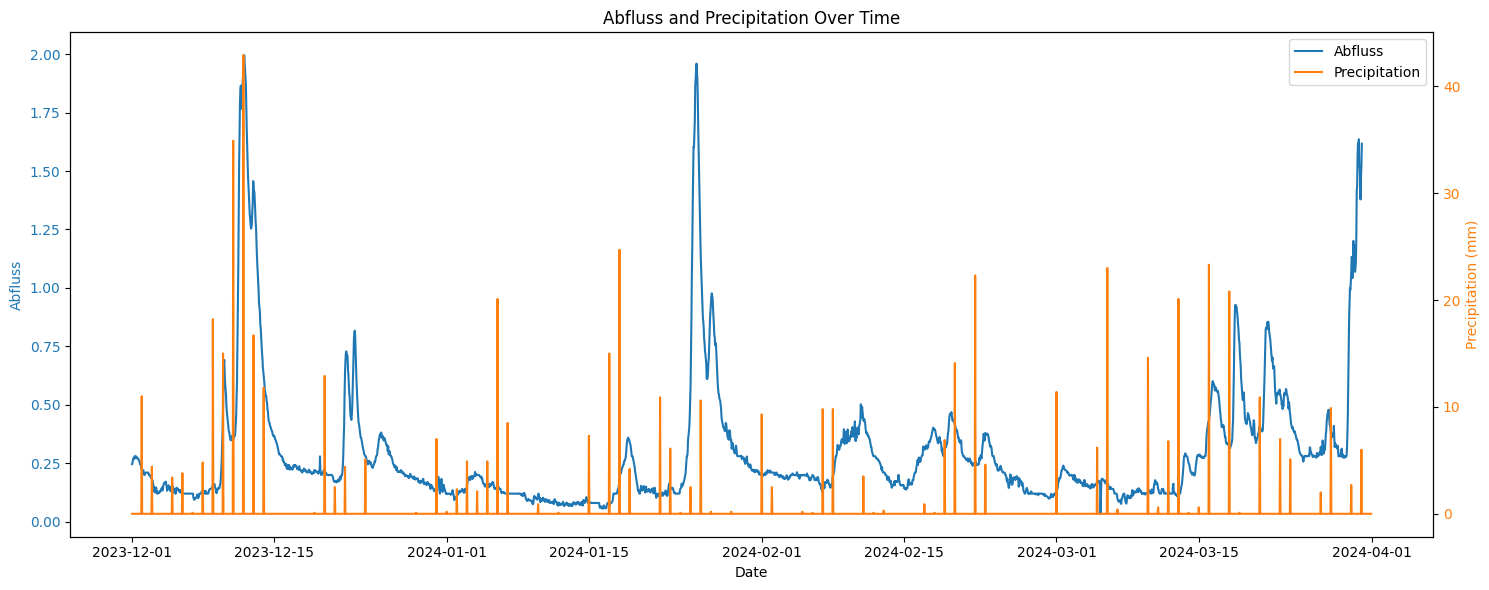

In [56]:
# Create figure and axis objects with a single subplot
fig, ax1 = plt.subplots(figsize=(15, 6))

# Plot Abfluss on primary y-axis
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Abfluss', color=color)
ax1.plot(merged_df.index, merged_df['Abfluss'], color=color, label='Abfluss')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Precipitation (mm)', color=color)
ax2.plot(merged_df.index, merged_df['Precipitation'], color=color, label='Precipitation')
ax2.tick_params(axis='y', labelcolor=color)

# Add title
plt.title('Abfluss and Precipitation Over Time')

# Add legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show plot
plt.show()

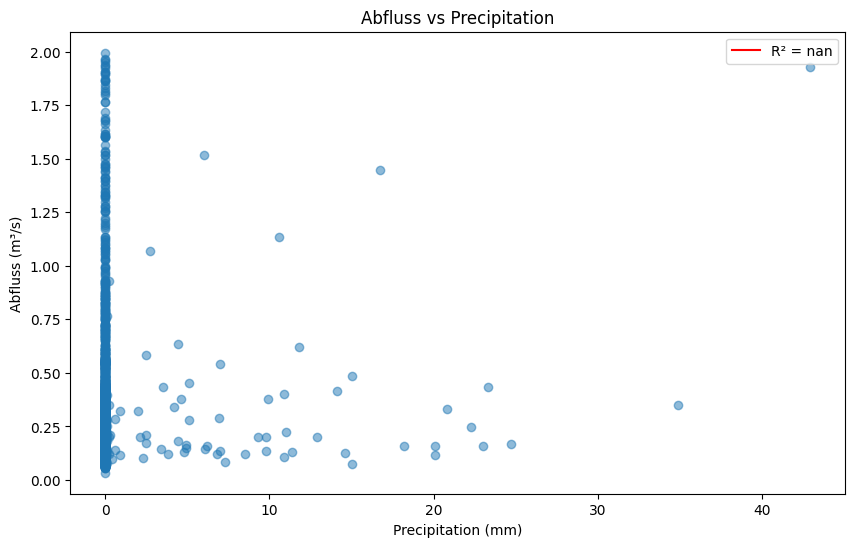

Regression Statistics:
Slope: nan
Intercept: nan
R-squared: nan
P-value: nan
Standard Error: nan


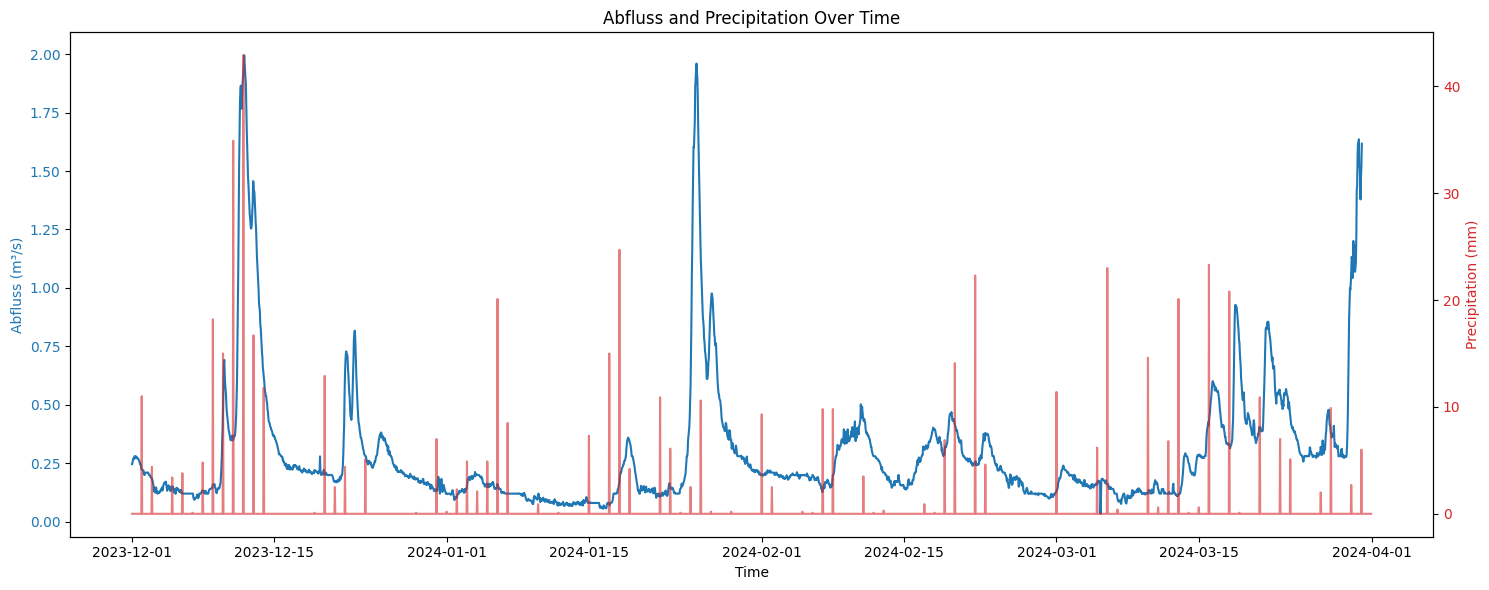

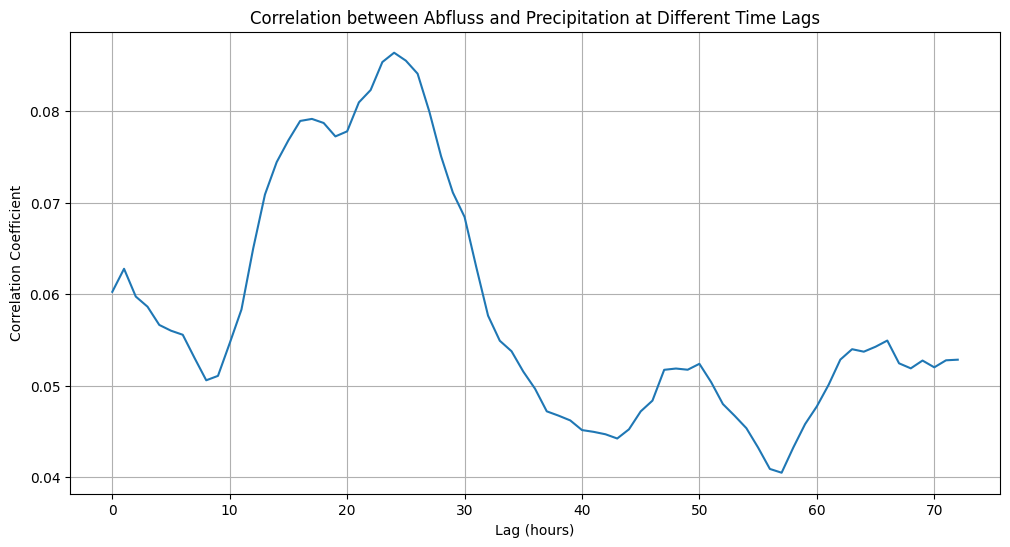

Maximum correlation of 0.086 at lag 24 hours


In [64]:
# Scatter plot of Abfluss vs Precipitation
plt.figure(figsize=(10, 6))
plt.scatter(merged_df['Precipitation'], merged_df['Abfluss'], alpha=0.5)
plt.xlabel('Precipitation (mm)')
plt.ylabel('Abfluss (m³/s)')
plt.title('Abfluss vs Precipitation')

# Add regression line
from scipy import stats

slope, intercept, r_value, p_value, std_err = stats.linregress(merged_df['Precipitation'], merged_df['Abfluss'])
line = slope * merged_df['Precipitation'] + intercept
plt.plot(merged_df['Precipitation'], line, color='red', label=f'R² = {r_value ** 2:.3f}')
plt.legend()
plt.show()

# Additional analysis
print("Regression Statistics:")
print(f"Slope: {slope:.4f}")
print(f"Intercept: {intercept:.4f}")
print(f"R-squared: {r_value ** 2:.4f}")
print(f"P-value: {p_value:.4e}")
print(f"Standard Error: {std_err:.4f}")

# Time series plot showing both variables
fig, ax1 = plt.subplots(figsize=(15, 6))

# Plot Abfluss on primary y-axis
color = 'tab:blue'
ax1.set_xlabel('Time')
ax1.set_ylabel('Abfluss (m³/s)', color=color)
ax1.plot(merged_df.index, merged_df['Abfluss'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Plot Precipitation on secondary y-axis
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Precipitation (mm)', color=color)
ax2.plot(merged_df.index, merged_df['Precipitation'], color=color, alpha=0.6)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Abfluss and Precipitation Over Time')
fig.tight_layout()
plt.show()

# Calculate correlation with different time lags
max_lag = 72  # hours
lags = range(0, max_lag + 1)
correlations = [merged_df['Abfluss'].corr(merged_df['Precipitation'].shift(lag)) for lag in lags]

plt.figure(figsize=(12, 6))
plt.plot(lags, correlations)
plt.xlabel('Lag (hours)')
plt.ylabel('Correlation Coefficient')
plt.title('Correlation between Abfluss and Precipitation at Different Time Lags')
plt.grid(True)
plt.show()

print(f"Maximum correlation of {max(correlations):.3f} at lag {lags[correlations.index(max(correlations))]} hours")

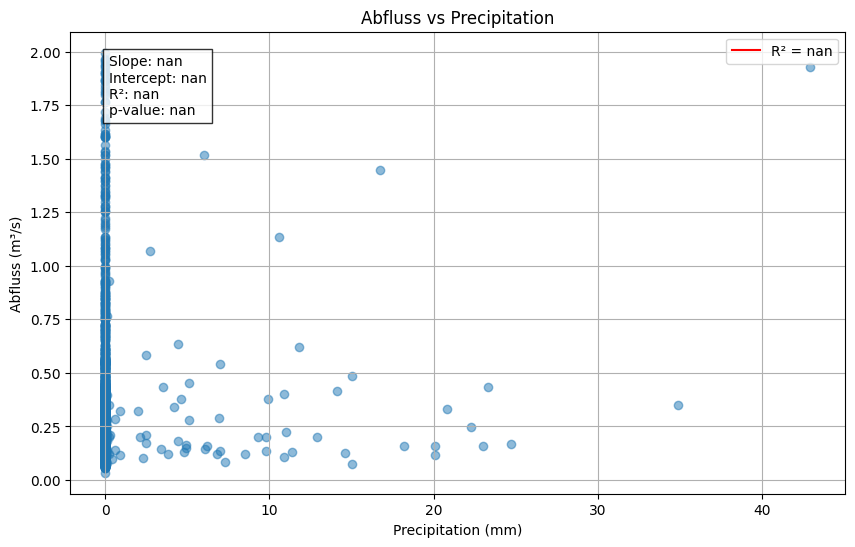


Correlation coefficient: 0.06024865672056534


In [59]:
# Scatter plot of Abfluss vs Precipitation
plt.figure(figsize=(10, 6))
plt.scatter(merged_df['Precipitation'], merged_df['Abfluss'], alpha=0.5)
plt.xlabel('Precipitation (mm)')
plt.ylabel('Abfluss (m³/s)')
plt.title('Abfluss vs Precipitation')
plt.grid(True)

# Add regression line
from scipy import stats

slope, intercept, r_value, p_value, std_err = stats.linregress(merged_df['Precipitation'], merged_df['Abfluss'])
line = slope * merged_df['Precipitation'] + intercept
plt.plot(merged_df['Precipitation'], line, color='red', label=f'R² = {r_value ** 2:.3f}')
plt.legend()

# Add text box with statistics
stats_text = f'Slope: {slope:.4f}\nIntercept: {intercept:.4f}\nR²: {r_value ** 2:.4f}\np-value: {p_value:.4e}'
plt.text(0.05, 0.95, stats_text, transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8), verticalalignment='top')

plt.show()

print("\nCorrelation coefficient:", merged_df['Precipitation'].corr(merged_df['Abfluss']))

In [60]:
# Feature Engineering
def create_features(df):
    df = df.copy()

    # Time-based features
    df['hour'] = df.index.hour
    df['day'] = df.index.day
    df['month'] = df.index.month
    df['day_of_week'] = df.index.dayofweek

    # Lagged features for Abfluss
    for lag in [1, 3, 6, 12, 24]:
        df[f'abfluss_lag_{lag}'] = df['Abfluss'].shift(lag)

    # Lagged features for precipitation
    for lag in [24, 48, 72]:
        df[f'precip_lag_{lag}'] = df['Precipitation'].shift(lag)

    # Rolling means for Abfluss
    for window in [6, 12, 24]:
        df[f'abfluss_rolling_mean_{window}'] = df['Abfluss'].rolling(window=window).mean()

    # Rolling sums for precipitation
    for window in [24, 48, 72]:
        df[f'precip_rolling_sum_{window}'] = df['Precipitation'].rolling(window=window).sum()

    return df.dropna()

# Create features
df_features = create_features(merged_df)
print("Features created. Dataset shape:", df_features.shape)
print("\nFeatures data sample:")
print(df_features.head())

Features created. Dataset shape: (2833, 20)

Features data sample:
                      Abfluss  Precipitation  hour  day  month  day_of_week  \
Timestamp                                                                     
2023-12-04 01:00:00  0.133333            0.0     1    4     12            0   
2023-12-04 02:00:00  0.141000            0.0     2    4     12            0   
2023-12-04 03:00:00  0.154000            0.0     3    4     12            0   
2023-12-04 04:00:00  0.160333            0.0     4    4     12            0   
2023-12-04 05:00:00  0.165667            0.0     5    4     12            0   

                     abfluss_lag_1  abfluss_lag_3  abfluss_lag_6  \
Timestamp                                                          
2023-12-04 01:00:00       0.146667       0.140000       0.126667   
2023-12-04 02:00:00       0.133333       0.142333       0.133667   
2023-12-04 03:00:00       0.141000       0.146667       0.131667   
2023-12-04 04:00:00       0.154000     

In [61]:
# Prepare for modeling
feature_cols = [col for col in df_features.columns if col != 'Abfluss']
X = df_features[feature_cols]
y = df_features['Abfluss']

# Split into train and validation sets (keeping temporal order)
split_idx = int(len(df_features) * 0.8)
X_train = X[:split_idx]
X_val = X[split_idx:]
y_train = y[:split_idx]
y_val = y[split_idx:]

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [39]:
# Train model
model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

model.fit(X_train_scaled, y_train)

GradientBoostingRegressor(max_depth=5, random_state=42)

RMSE: 0.031
R2 Score: 0.988


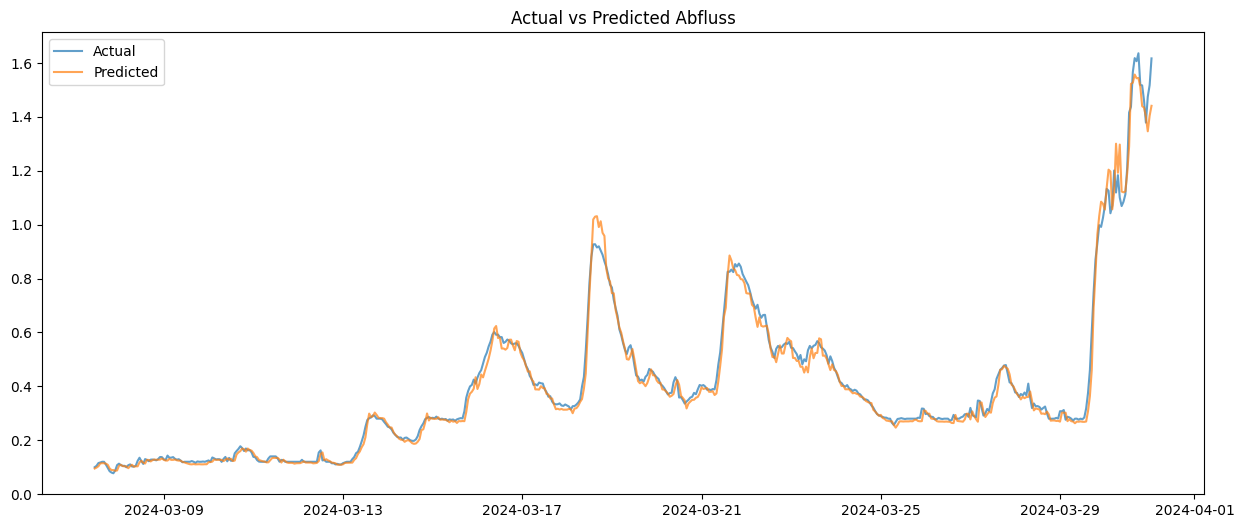

In [62]:
# Evaluate model
# Make predictions
y_pred = model.predict(X_val_scaled)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)

print(f"RMSE: {rmse:.3f}")
print(f"R2 Score: {r2:.3f}")

# Plot actual vs predicted
plt.figure(figsize=(15, 6))
plt.plot(y_val.index, y_val.values, label='Actual', alpha=0.7)
plt.plot(y_val.index, y_pred, label='Predicted', alpha=0.7)
plt.title('Actual vs Predicted Abfluss')
plt.legend()
plt.show()


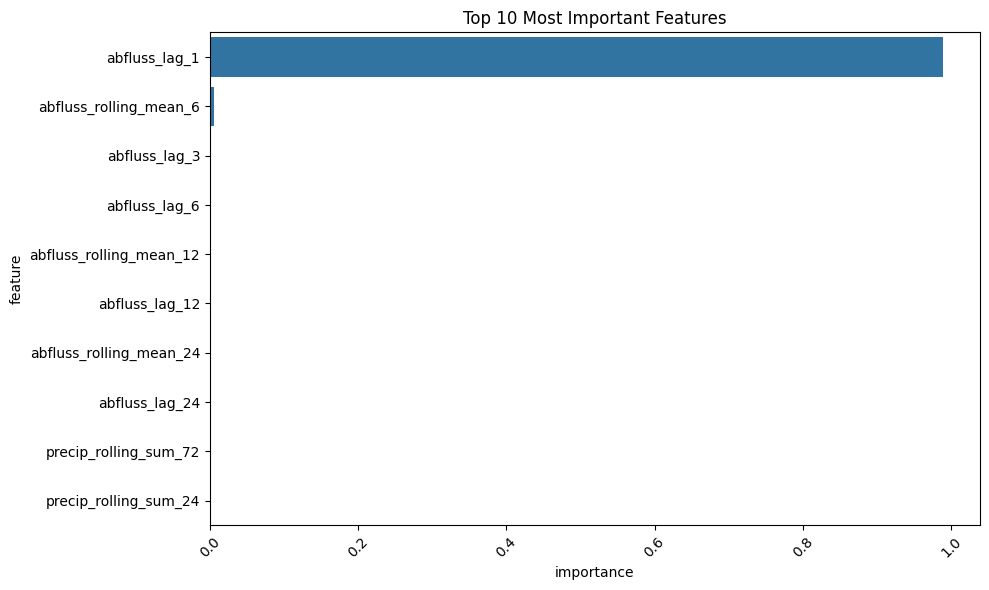

In [63]:
# Feature importance visualization
importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance.head(10), x='importance', y='feature')
plt.title('Top 10 Most Important Features')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()